In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 28.0
xtick = matplotlib.ticker.FuncFormatter(lambda x, pos: '%.1f'%(x*10**3))
from scipy.stats import norm, chi2
import healpy as hp
import numpy as np
import os.path
import classyVS as vs
reload(vs);

### Set all parameters, use Micro-X ###
mx_params = vs.micro_x_params.copy()
mx_lon = np.array([-105., -65., -25., 25., 65., 105.])
mx_lat = 25.
mxvs = vs.velocitySpectroscopy(halo=374, instrument_params=mx_params, verbose=False)
data_an = vs.readVSData(374, 'analytic')
# data_fill = vs.readVSData(h, 'fill')

0.00592873726437 0.966634480105
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.777700912753 318.605647506
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


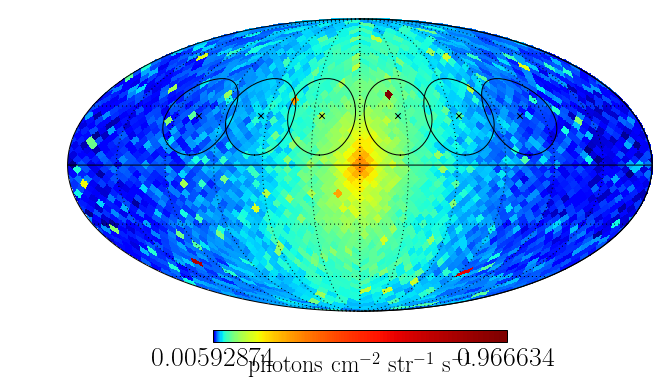

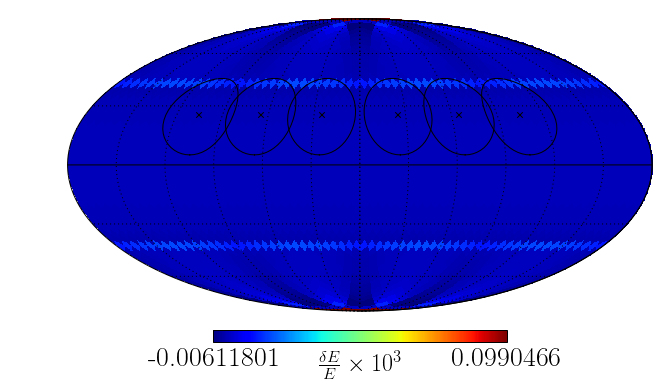

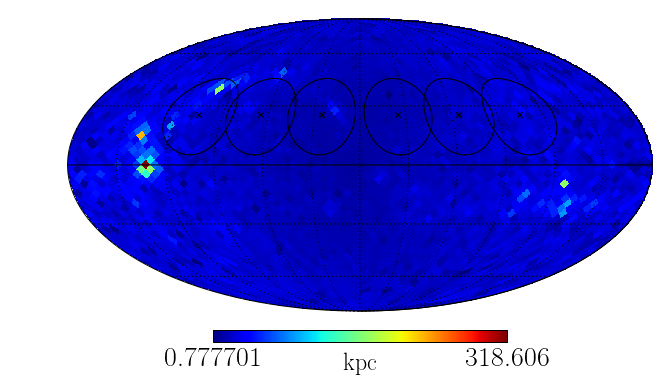

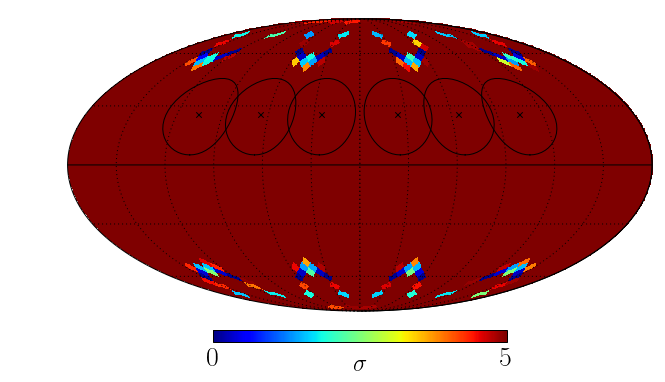

In [2]:
def map_frills(lon=[-105., -65., -25., 25., 65., 105.], lat=25.0, beamrad=20.0):
    #graticule
    hp.graticule();
    # plot beams
    beamargs = {'rot': (180,0,0), 'lonlat': True, 'c': 'black'} 
    bphi = np.linspace(0., 360., 50)
    bthe = (90.0-beamrad)*np.ones_like(bphi)
    for l in lon:
        beamargs['rot'] = (180.0-l, lat, 0.0)
        hp.projscatter(0, 90.0, marker='x', s=30, **beamargs)
        hp.projplot(bphi, bthe, **beamargs)
    # make unit labels bigger
    f = plt.gcf().get_children()
    CbAx = f[2]
    unit_text_obj = CbAx.get_children()[1]
    unit_text_obj.set_fontsize(24.0)
    unit_text_obj.set_va('top')
#     unit_text_obj.set_y(1.0)

# run the healpix binning
mxvs.rotateHaloInPlace()
hpspec = mxvs.healpix(mode='pix', nside=16)

# make Moll
mapargs = {'rot': (180,0,0), 'margins': (0,0,0,0)} 

# properly scale flux for astro-h to get number counts
ahs = 1.0*0.37892243899248773*300.0

hp.mollview(hpspec['flux'], norm='log', title='', \
            unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', **mapargs);
# hp.mollview(hpspec['flux'], norm='log', title='', min = .01, max=0.5, \
#             unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', **mapargs);
#             unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', flip='geo', **mapargs);
print np.min(hpspec['flux']), np.max(hpspec['flux'])
map_frills()
# plt.savefig('../img/flux_map_374.png', bbox_inches='tight', pad_inches=0)

# hp.mollview(hpspec['centroid']*10**3, min=-1.0, max=1.0, title='', \
#             unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs);
hp.mollview(hpspec['centroid'], title='', \
            unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs);
map_frills()
# plt.savefig('../img/line_map_374.png', bbox_inches='tight', pad_inches=0)

hp.mollview(hpspec['radius'], title='', unit=r'kpc', **mapargs);
print np.min(hpspec['radius']), np.max(hpspec['radius'])
map_frills()

hp.mollview(np.abs(hpspec['centroid']/hpspec['sigma_centroid'])*ahs**0.5, min = 0, max=5, \
            title='', unit=r'$\sigma$', **mapargs);
map_frills()
# plt.savefig('../img/sigma_map_374.png', bbox_inches='tight', pad_inches=0)

In [ ]:
###### comparison of dF/dE for both the N-body and analytic models ########
reload(vs);
obsinds = range(0,11,2) # micro-X uses half of the saved data
fig, axes = plt.subplots(len(obsinds), 1, figsize=(10, 10), sharex=True, sharey=True) # scale x-axis by 10**3
fig.subplots_adjust(hspace=0)
xtick = ticker.FuncFormatter(lambda x, pos: '%.1f'%(x*10**3))


ran = 2.0e-3
yr = 0.55
for ax in axes:
    ax.xaxis.set_major_formatter(xtick)    
    ax.set_yticks([])
    ax.set_xlim(-ran, ran);
    ax.set_ylim(0.0, yr);

nbins = 64
xp = np.linspace(-ran,ran,200)
db = (2*ran)/nbins

for mxi, ax in zip(obsinds, axes):
                        
    # bin the spectrum dF/dE from particles
    hist, binc = vs.spectroscopy_histogram(pos, vel, partmass, \
                    lon=data_nb['l'][mxi], nbins=nbins, ran=(-ran,ran), **mx_params)

    # plot along with the models
    ax.plot(binc, hist, 'k-', drawstyle='steps-mid', \
            lw=0.6, label=r'$\ell=%.1f^\circ$'%data_nb['l'][mxi])
#     ax.plot(xp, data_nb['ns'][mxi]*db*norm.pdf(xp, loc=data_nb['centroid'][mxi], \
#                     scale=data_nb['sigma_line'][mxi]), '-', lw=0.4, c=color)
    ax.plot(xp, data_an['ns'][mxi]*db*norm.pdf(xp, loc=data_an['centroid'][mxi], \
                    scale=data_an['sigma_line'][mxi]), 'k--')
    
    ax.plot([0.,0.],[0.,yr], 'k:', lw=0.4);
    ax.text(-ran*0.95, yr*0.9, '$\ell=%.0f^\circ$'%data_nb['l'][mxi], va='top', fontsize=24);
    
    
# ax.set_title(r'Observed spectrum')
ax.set_xlabel(r'$\frac{\delta E}{E} \times 10^3$')
fig.text(0.07, 0.5, r'Normalized $\frac{d\mathcal{F}}{dE}$', va='center', rotation='vertical')
# axes[3].set_ylabel(r'$\frac{d\mathcal{F}}{dE}$ (arbitrary units)')
# ax.legend(loc='upper right', fontsize=28)

# fig.savefig('../img/dfde_pointings.png', bbox_inches='tight')

In [ ]:
#### Halo 374 results! ####
for h in mws.allHaloes:
    an = vs.readVSData(h, 'analytic')
    nb = vs.readVSData(h, 'nbody')
    ell = nb['l'][::2]
    cent_nb = nb['centroid'][::2]
    sig_nb = nb['sigma_centroid'][::2]
    cent_an = an['centroid'][::2]

    # plot the other models
    torad = np.pi/180.
    vcosb = -220.0/3.0e5*np.cos(25.*torad)

    # statistics for the numerically-integrated model
    dof_model = len(ell)-2 # lose 2 dof for the fitted NFW parameters
    nsigma_model = (cent_nb-cent_an)/sig_nb
    chi2_model = np.sum(nsigma_model**2)/dof_model
    
    dof_sin = len(ell)
    nsigma_sin = (cent_nb-vcosb*np.sin(ell*torad))/sig_nb
    chi2_sin = np.sum(nsigma_sin**2)/dof_sin

    dof_null = len(ell)
    nsigma_null = cent_nb/sig_nb
    chi2_null = np.sum(nsigma_null**2)
    sigma_null = chi2_null**0.5
    
    print "Halo", h, ": chi2_model =", chi2_model, ", chi2_sin =", chi2_sin, ", sigma =", sigma_null


In [ ]:
reload(vs);  
hpspec = vs.spectroscopy_healpix(mode='pix', pos=pos, vel=vel, mass=partmass, nside=8, **mx_params)


def plot_beams(lon=[-85., -65., -45., -25., 0.0, 25., 45., 65., 85.], lat=25.0, beamrad=20.0):
    beamargs = {'rot': (180,0,0), 'lonlat': True, 'c': 'black'} 
    bphi = np.linspace(0., 360., 50)
    bthe = (90.0-beamrad)*np.ones_like(bphi)
    for l in lon:
        beamargs['rot'] = (180.0-l, lat, 0.0)
        hp.projplot(bphi, bthe, **beamargs)
def bigger_units():
    f = plt.gcf().get_children()
    CbAx = f[2]
    unit_text_obj = CbAx.get_children()[1]
    unit_text_obj.set_fontsize(24.0)
    unit_text_obj.set_va('top')

# make Moll
mapargs = {'rot': (180,0,0), 'margins': (0,0,0,0)} 

# properly scale flux for astro-h to get number counts
ahs = 1.0*0.37892243899248773*300.0

ahs = 1.0

hp.mollview(hpspec['flux']*ahs**-1, norm='log', title='', min=0.015, max=0.2, \
            unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', **mapargs);
#             unit=r'$\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}$', flip='geo', **mapargs);
plot_beams(lon=mx_lon)
hp.graticule();
bigger_units()

hp.mollview(hpspec['centroid']*10**3, min=-1.0, max=1.0, title='', \
            unit=r'$\frac{\delta E}{E} \times 10^3$', **mapargs);
plot_beams(lon=mx_lon)
hp.graticule();
bigger_units()

hp.mollview(np.abs(hpspec['centroid']/hpspec['sigma_centroid']), min = 0, \
            title='', unit=r'$\sigma$', **mapargs);
plot_beams(lon=mx_lon)
hp.graticule();
bigger_units()

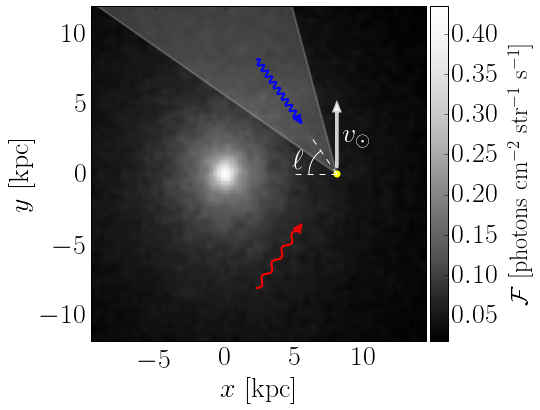

In [65]:
####### Figure of Halo 374 ########
from matplotlib.patches import Polygon
from scipy.ndimage.filters import gaussian_filter
fsz = 6
fig, ax = plt.subplots(1, 1, figsize=(fsz, fsz))

ran = 12.0 #275.7
nbins=256

prefac = 1.44630429319e-06
pixar = (2*ran/nbins)**2
mult = prefac/(pixar/8**2)

hist, xe, ye = np.histogram2d(mxvs.posar[:,0], mxvs.posar[:,1], 
        bins=nbins, range=[[-0.8*ran, 1.2*ran], [-ran, ran]])
gaussian_filter(hist, 2.0, output=hist, mode='reflect')
hist *= mult

imargs = {'cmap': plt.cm.Greys_r, 'origin': 'lower', 
          'extent': [-0.8*ran, 1.2*ran, -ran, ran], 'interpolation': 'nearest'}
im = ax.imshow(hist.T, **imargs)

# diagram of velocity spectroscopy
rfov = 200.
rot = -55.
torad = np.pi/180
polyverts = np.array([[0.,0.],[-rfov*np.cos((rot-20.0)*torad),-rfov*np.sin((rot-20.0)*torad)],
                      [-rfov*np.cos((rot+20.0)*torad),-rfov*np.sin((rot+20.0)*torad)]])
polyverts[:,0] += 8.0
fov = Polygon(polyverts, lw=2, color='white', alpha=0.2)
ax.add_patch(fov)
ax.scatter(8.0, 0.0, facecolor='yellow', s=50, lw=0)
ax.arrow(8.0, 0.5, 0.0, 4.0, head_width=0.4, head_length=0.5, lw=3, fc='white', ec='white', alpha=0.8)
ax.text(8.4, 2.0, '$v_\odot$', color='white')

cs = np.cos(rot*torad)
sn = np.sin(rot*torad)

# arc
ax.plot([8.0-3, 8.0], [0.0, 0.0], 'w--', lw=1)
ax.plot([8.0-3*cs, 8.0], [-3*sn, 0.0], 'w--', lw=1)
ang = np.linspace(0.0, torad*rot, 30)
ax.plot(8.0-2*np.cos(ang), -2*np.sin(ang), 'w')
ax.text(4.8, 0.3, '$\ell$', color='white')

# blue arrow
arad = 5.0
apos=arad
xpos=np.linspace(0.0, 1.0, 100)
ypos=0.2*np.sin(10*2*np.pi*xpos)
xpos *= apos
xa = -cs*xpos+sn*ypos
ya = -sn*xpos-cs*ypos
xa += 8.0-arad*cs
ya += -sn*arad
ax.plot(xa, ya, lw=2, c='blue')
ax.arrow(8.0-arad*cs, -sn*arad, 0.01*cs, 0.01*sn, 
         head_width=0.5, head_length=0.6, lw=2, fc='blue', ec='blue', alpha=0.8)

# red arrow
xpos=np.linspace(0.0, 1.0, 100)
ypos=0.2*np.sin(4*2*np.pi*xpos)
xpos *= apos
xa = -cs*xpos+sn*ypos
ya = sn*xpos+cs*ypos
xa += 8.0-arad*cs
ya += sn*arad
ax.plot(xa, ya, lw=2, c='red')
ax.arrow(8.0-arad*cs, sn*arad, 0.01*cs, -0.01*sn,
         head_width=0.5, head_length=0.6, lw=2, fc='red', ec='red', alpha=0.8)

# ax.axis('off')
ax.set_xlim(-0.8*ran, 1.2*ran)
ax.set_ylim(-ran, ran)

# print ax.get_position()
cax = fig.add_axes([0.91, 0.125, 0.04, 0.775])
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label('$\mathcal{F}~[\mathrm{photons~cm^{-2}~str^{-1}~s^{-1}}]$', rotation=90, fontsize=24, labelpad=10)

ax.set_ylabel(r'$y$ [kpc]')
ax.set_xlabel(r'$x$ [kpc]')
ax.set_axis_bgcolor('black')

# fig.savefig('../img/vspec_diagram.png', bbox_inches='tight', dpi=300)

In [ ]:
#### Halo 374 results! ####
h = 374
an = vs.readVSData(h, 'analytic')
fill = vs.readVSData(h, 'fill')
nb = vs.readVSData(h, 'nbody')
ell = nb['l'][::2]
cent_nb = nb['centroid'][::2]
sig_nb = nb['sigma_centroid'][::2]
cent_an = an['centroid'][::2]
ell_fill = fill['l']
cent_fill = fill['centroid']

# plot the photons and their lines
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.errorbar(ell, cent_nb*10**3, yerr=sig_nb*10**3, \
            c='blue', fmt='.', markersize=10, label='N-body')

# plot the other models
torad = np.pi/180.
vcosb = -220.0/3.0e5*np.cos(25.*torad)
ax.plot(ell_fill, cent_fill*10**3, 'k-', label='Analytic NFW')
ax.plot(ell_fill, vcosb*np.sin(ell_fill*torad)*10**3, 'r--', label=r'$(v_\odot/c)\sin \ell \cos b$')
ax.plot([-120, 120], [0,0], 'k-', lw=0.4)

# statistics for the numerically-integrated model
dof_model = len(ell)-2 # lose 2 dof for the fitted NFW parameters
nsigma_model = (cent_nb-cent_an)/sig_nb
chi2_model = np.sum(nsigma_model**2)/dof_model
print "Model: chi^2_red =", chi2_model
dof_sin = len(ell)
nsigma_sin = (cent_nb-vcosb*np.sin(ell*torad))/sig_nb
chi2_sin = np.sum(nsigma_sin**2)/dof_sin
print "Sine: chi^2_red =", chi2_sin

dof_null = len(ell)
nsigma_null = cent_nb/sig_nb
chi2_null = np.sum(nsigma_null**2)
sigma_null = chi2_null**0.5
print 'sigma_null', sigma_null

# print 100*np.max(np.abs(1.0 - vcosb*np.sin(ell_fill*torad)/cent_fill))

# frills
ax.set_ylabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_xlabel(r'$\ell$ ($^{\circ}$)')
ax.set_xlim(-120., 120.)
ax.invert_xaxis()
ax.set_ylim(-1.2, 1.2)
ax.grid(True)
ax.legend(loc='upper left', fontsize=28)

# fig.savefig('../img/de_vs_l_800.png', bbox_inches='tight')
# fig.savefig('../img/de_vs_l.png', bbox_inches='tight')


In [ ]:
'''
An example plot to show how sampling is done

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
zoom = 800 # kpc
ax.set_xlim([-0.5*zoom, 0.5*zoom])
ax.set_ylim([-0.5*zoom, 0.5*zoom])
ax.set_title(r'MW halo: Sampling the FOV')
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
cpos, _, _ = vsh.sample_los(pos, vel, beam_radius=20.0)
sfilt = np.abs(pos[:,2]) < 1.0 # filter all particles into a thin 1 kpc slab to make plotting easier
ax.scatter(pos[sfilt][:,0], pos[sfilt][:,1], s=0.5, c='black', lw=0)
ax.scatter(cpos[:,0], cpos[:,1], s=2.0, c='red', lw=0)
'''

In [ ]:
# Code to test uniformity of 3d rotation sampling.
# Looks good!
import velocitySpectroscopy as vs
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import velocitySpectroscopy as vs

reload(vs);

fig = matplotlib.pyplot.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection = '3d')

whisk = np.array([[-0.02, 0.0, 1.0], [0.02, 0.0, 1.0]])

for i in xrange(5000):
#     rot = vs.generateRotationMatrix()
#     print np.dot(rot,rot.T)
#     w = np.dot(whisk, rot)
#     print w
    vs.rotateInPlace(whisk)
    w = whisk.copy()
    ax.plot(w[:,0], w[:,1], w[:,2], color = 'b');

ax.set_xlim([-1.1, 1.1]);
ax.set_ylim([-1.1, 1.1]);
ax.set_zlim([-1.1, 1.1]);